# Calculating dNBR for Paradise Fire, Butte County California 2018


2018 was the year of the devistating Paradise Fire in Butte County California.  By using imagery available on the Descartes Labs Platform and image classification we can determine the fire scar and the area of the fire scar 




<img src="http://gsp.humboldt.edu/OLM/Courses/GSP_216_Online/images/NBR-formula.jpg">

The Normalized Burn Ratio is a spatial index utilized in Remote Sensing. NBR allows one to determine from spectral signatures using two bands, near infrared  and shortwave infrared, an area impacted by fire.  Once an area has been identified using spectral signatures, the severity of the burned area can be determined.  


Determining burned areas and burn serverity has practical emergency management and disaster preparedness applications.  Relief efforts can be focus for instance in geographies that have been classified with high severity burn.  Studying the spread of a fire can help disaster prepardness management individuals understand what a future diasters may look like in the area or similiar areas and how event can be mitigated in the future.  


credit: http://gsp.humboldt.edu/OLM/Courses/GSP_216_Online/lesson5-1/NBR.html

In [1]:
#Import all of your Modules
from __future__ import print_function
import descarteslabs as dl
import matplotlib.pyplot as plt
import pkg_resources
import numpy as np
import ipywidgets as widgets
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual

import warnings
warnings.filterwarnings('ignore')

from mpl_toolkits.axes_grid1 import make_axes_locatable 
from copy import deepcopy

from skimage import measure
from skimage.morphology import disk
from skimage.morphology import dilation #, erosion, opening, closing, white_tophat from skimage.morphology import disk

#bc skimage is incompatibalbe with versions of numpy greater than 1.40 have to port this code to bake ndarrays work well 
import numpy as np
# After numpy 1.15, a new backward compatible function have been implemented.
# See https://github.com/numpy/numpy/pull/11966
from distutils.version import LooseVersion as Version
old_numpy = Version(np.__version__) < Version('1.16')
if old_numpy:
    from numpy.lib.arraypad import _validate_lengths
else:
    from numpy.lib.arraypad import _as_pairs


from pprint import pprint
from pylab import *


/miniconda3/envs/descarteslabs/lib/python3.7/site-packages/geojson/mapping.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/miniconda3/envs/descarteslabs/lib/python3.7/site-packages/ipyleaflet/leaflet.py:78: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  options = List(trait=Unicode).tag(sync=True)
/miniconda3/envs/descarteslabs/lib/python3.7/site-packages/xarray/core/utils.py:10: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping, MutableMapping, MutableSet
/miniconda3/envs/descarteslabs/lib/python3.7/site-packages/xarray/core/indexing.py:5: DeprecationWarning: Using or importing the ABCs from 'collec

In [2]:
#import the different Descartes Labs Services: Places, Metadata and Raster

places_client = dl.Places()
metadata_client = dl.Metadata()
raster_client = dl.Raster()



In [3]:
#need to define AOI geometry

aoi_geometry = {
    'type': 'Polygon',
    'coordinates':((
        (-122.15112447738649,39.434486015343396),
        (-120.561980009079,39.434486015343396),
        (-120.561980009079,41.37081052519474),
        (-122.15112447738649,41.37081052519474),
        (-122.15112447738649,39.434486015343396)
    ),)
}

In [4]:
#Time to search for imagery over AOI within specific timeframes 

pre_scenes, ctx = dl.scenes.search(aoi_geometry,
                                   products=["sentinel-2:L1C"],
                                   start_datetime='2018-10-30',
                                   end_datetime='2018-11-07',
                                   limit=500)


post_scenes, ctx = dl.scenes.search(aoi_geometry,
                               products= ["sentinel-2:L1C"],
                               start_datetime='2018-11-26',
                               end_datetime='2018-12-30',
                               limit=500)


In [5]:
print("Pre Fire Scenes: {} ||| Post Fire Scenes: {}".format(len(pre_scenes), len(post_scenes)))

Pre Fire Scenes: 30 ||| Post Fire Scenes: 105


In [10]:
#Create a list of Pre and Post fire scenes

pre_scenes = pre_scenes.sorted("properties.date")

pre_scenes.each.properties.id

pre_scene_ids =[]

for i in pre_scenes.each.properties.id:
        pre_scene_ids.append(i)
        
#get post scene id 
post_scenes = post_scenes.sorted("properties.date")

post_scenes.each.properties.id

post_scene_ids =[]

for i in post_scenes.each.properties.id:
        post_scene_ids.append(i)


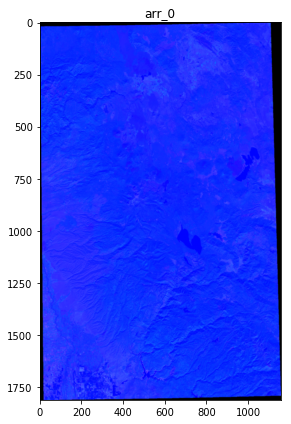

In [11]:

pre_arr, pre_meta = raster_client.ndarray(pre_scene_ids,
                                      bands=["swir2", "nir","alpha"],
                                      resolution=120,
                                      scales=[[0,10000],[0,10000],[0,1]],
                                      data_type="Byte",
                                      cutline=aoi_geometry)



dl.scenes.display(pre_arr,
                  bands_axis=-1,
                  title="arr_0",
                  size=6)

In [12]:
arr = pre_arr.astype('double')
pre_nbr = (arr[:,:,1]-arr[:,:,0])/(arr[:,:,1]+arr[:,:,0]+1e-9)

pre_nbr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

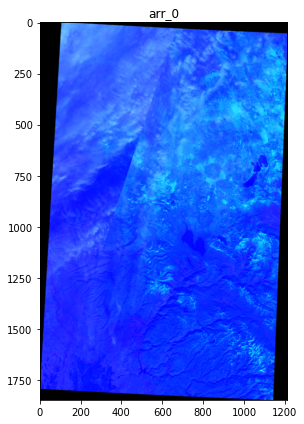

In [13]:
#the last scene has the lease cloud cover 
post_arr, post_meta = raster_client.ndarray(post_scene_ids,
                                      bands=["swir2", "nir", "alpha"],
                                      resolution=120,
                                      scales=[[0,10000],[0,10000], [0,1]],
                                      data_type="Byte",
                                      cutline=aoi_geometry)

dl.scenes.display(post_arr,
                  bands_axis=-1,
                  title="arr_0",
                  size=6)

In [14]:
arr = post_arr.astype('double')
post_nbr = (arr[:,:,1]-arr[:,:,0])/(arr[:,:,1]+arr[:,:,0]+1e-9)

post_nbr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
#  get the shapes of pre_nbr, post_nbr, if shapes are different cannot calculate the change.  arrays must be of the same dimensions

pre_arr.shape , post_arr.shape


((1812, 1157, 3), (1847, 1213, 3))

In [16]:
#calulate delta 

dnbr = pre_nbr - post_nbr

dnbr.max()

ValueError: operands could not be broadcast together with shapes (1812,1157) (1847,1213) 

In [ ]:
print(pre_nbr.max(), pre_nbr.min(), type(pre_nbr)) 
print(post_nbr.max(), post_nbr.min(), type(post_nbr)) 
print(dnbr.max(), dnbr.min(), type(dnbr))

In [ ]:
#plot the NBRs and dNBR 

pre_plot = dl.scenes.display(pre_nbr,
                  bands_axis=-1,
                  title="Pre-fire NBR",
                  size=6,
                  colormap='hsv')

post_plot = dl.scenes.display(post_nbr,
                  bands_axis=-1,
                  title="post-fire NBR",
                  size=6,
                  colormap='hsv')

dnbr_plot = dl.scenes.display(dnbr,
                  bands_axis=-1,
                  title="fire dNBR",
                  size=6,
                  colormap='hsv')

pre_plot, post_plot, dnbr_plot

plt.subplot(pre_plot, post_plot, dnbr_plot)

In [ ]:
#Now it's time to create and index to determine the burn serverity,  this particular threshold
#comes from the USGS FireMon program 

#Burn Severity Index 
# < -0.25   High post-fire regrowth
# -0.25 to -0.1 Low post-fire regrowth
# -0.1 to +0.1 Unburned
# 0.1 to 0.27 Low-severity burn
# 0.27 to 0.44 Moderate-low severity burn
# 0.44 to 0.66 Moderate-high severity burn
# > 0.66    High-severity burn


# First make a copy of the delta NBR array

dnbr_catagories = deepcopy(dnbr)
dnbr_catagories[(dnbr<0.1)]=0
dnbr_catagories[((dnbr >=0.1) & (dnbr <0.27))]=1
dnbr_catagories[(dnbr >=0.27) & (dnbr <0.44)]=2
dnbr_catagories[(dnbr >=0.44) & (dnbr <0.66)]=3
dnbr_catagories[(dnbr >=0.66)]=4

butte_nbr = dnbr_catagories

# Plot the severity index map we just derived
ax = plt.figure(figsize=[10,10])
plt.title('Camp Fire Burn Severity Index', fontsize=22)
plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off', 
    labelleft='off')
ax = plt.imshow(butte_nbr)

ax1 = plt.gca()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.4)
cax.tick_params(
axis='x',
which='both',
bottom='off',
top='off',
labelbottom='off', 
cbar = plt.colorbar(ax,cax=cax,ticks=[0, 1,2,3, 4]) 
cbar.ax.set_yticklabels(['N/A', 'Low', 'Moderate-low', 'Moderate-high', 'High'])

In [ ]:
#Derive the burn scar mask and the fire perimeter 

# We mask out all pixels appearing unburned in the severity index map
image = (butte_nbr>1.0)*1.0

# We use the skimage package to dilate this mask and make it smoother at the edges
selem=disk(6)
dilated = dilation(image, selem)

# We find the countours on the dilated mask
contours = measure.find_contours(dilated, 0.8)

# Display the image and plot all contours found

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image, interpolation='nearest', cmap=plt.cm.gray) 
maxlen=0
for item in contours:
    if len(item)>maxlen:
        maxlen=len(item) #find which of the detected contours is the fire perimeter

for n, contour in enumerate(contours): 
    if len(contour)==maxlen:
        the_contour = contour
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Paradise Burn Scar and Fire Contour', fontsize=24)

In [ ]:
# Recopy the original dNBR as the previous operations altered the values
dnbr_catagories = deepcopy(dnbr_catagories)
fire_dnbr = dnbr_catagories 
print(fire_dnbr.min(), fire_dnbr.max())

# Get extent of a pixel grid for the fire scar
nx, ny = (fire_dnbr.shape[0], fire_dnbr.shape[1])
x = np.arange(-100, 100, 1)
y = np.arange(0, 32000, 1)
fire_mask = measure.grid_points_in_poly((nx, ny), the_contour ) 
burned_pixels = fire_dnbr[fire_mask]*1000 #scaled by 1000 to get dNBR
fig, ax = plt.subplots(figsize=(10,6))
counts, bins, patches = ax.hist(burned_pixels, bins=80, facecolor='blue', edgecolor='gray')

# Make matplotlib work for you and not against you
ax.set_xlim([-500, 1400])
ax.set_ylim([0, 32000])
ax.set_ylabel('Severity frequency (pixels)', fontsize=12)
ax.set_xlabel('dNBR', fontsize=12)
ax.set_xticks(range(-500,1400,100))
ax.set_xticklabels( range(-500,1400,100), rotation=45 )
ax.axvline(x=-100,lw=1.33, ls='--')
ax.axvline(x=100,lw=1.33, ls='--')
ax.annotate('Unburned', xy=(0, 31000), xycoords='data',horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.annotate('Increasing burn severity', xy=(150, 31000), xycoords='data', horizontalalignment='left', verticalalignment='center', fontsize=12)
ax.arrow(700, 31000, 250, 0, shape='full', lw=2, length_includes_head=True,head_width=500,head_length=50, fc='k', ec='k')
ax.fill_between(x, 0, 32000, color='grey', alpha=0.5)

# And now let's use an intuitive color scheme to highlight the different burn ˓→severity categories
for patch, binm in zip(patches, bins): 
    if (binm >= 660) :
        patch.set_facecolor('red')
    if (binm < 660) & (binm >= 440) : 
        patch.set_facecolor('orange') 
    if (binm < 440) & (binm >= 270) : 
        patch.set_facecolor('yellow') 
    if (binm < 270) & (binm >= 100) :
        patch.set_facecolor('green') 
    if binm <100:
        patch.set_facecolor('blue')
ax.set_title('Burn severity index histogram within fire contour', fontsize=14)

In [ ]:
#fire acreage stats 

In [ ]:
# Acres reported by officials: 142000 acres
# Acreage of a square meter
acrem = 0.000247105

# Compute burn severity category respective acreage relative to total burned pixels
total_within_contour = fire_mask.sum()*30*30*acrem
total = (burned_pixels>=100).sum()*30*30*acrem
low = ((burned_pixels >=100) & (burned_pixels <270)).sum()*30*30*acrem
mlow = ((burned_pixels >=270) & (burned_pixels <440)).sum()*30*30*acrem
mhigh =((burned_pixels >=440) & (burned_pixels <660)).sum()*30*30*acrem
high = ((burned_pixels >=660)).sum()*30*30*acrem
print('total acres within perimeter', total_within_contour) 
print('total burned acres', total)
print('low severity', low/total)
print('mlow severity', mlow/total)
print('mhigh severity', mhigh/total )
print('high severity', high/total )
print('not burned', (burned_pixels<100).sum()*30*30*acrem/total)

# Compute burn acreage estimation percent error
actual = 140000
ac_err = (total-actual)/actual*100
print('Acreage estimation percent error: %0.2f' %ac_err)

In [ ]:
# Plot these relative stats as a pie chart using pylab
acreages = [low/total*100, mlow/total*100, mhigh/total*100, high/total*100]
labels = ['Low', 'Moderate-low', 'Moderate-high', 'High']
explode=(0, 0, 0, 0.05)
facecolor = ['green', 'yellow', 'orange', 'red']
pie(acreages, explode=explode, labels=labels, colors = facecolor, autopct='%.1f%%',shadow=True, startangle=90)
title('Burn severity area fractions')
fname = 'campfire_pie_chart.png'
plt.savefig(fname, bbox_inches='tight')